# Лабораторная работа №2

## Исходное задание
**Вариант №4**

Для набора данных потенциальных покупателей разработать модель для
прогнозирования общей суммы, которую клиенты готовы заплатить за новый
автомобиль. Построить регрессионную модель для целевого признака
«Car Purchase Amount» (сумма покупки автомобиля) от остальных входных
признаков.
a. Модель CART
b. Градиентный бустинг

Производим импорт необходимых библиотек. 
По сравнению с предыдущей работой добавляются только DecisionTreeRegressor и GradientBoostingRegressor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import json

## 1). Загрузка и подготовка наборов данных

По аналогии с предыдущей работой подготовим 4 набора данных (исходный, расширенный, исходный масштабированный, расширенный масштабированный), в сжатой форме и уже без проведения анализа.

Загружаем исходный набор данных, берём только числовые поля, и дополнительно проводим очистку, отбрасывая недозалпоненное поле Gender (просто не включая его в очищенный набор данных).

In [2]:
data = pd.read_csv("V4.csv")
cleaned_data = data.loc[:,['Age','Annual Salary', 'Credit Card Debt', 'Net Worth', 'Car Purchase Amount']]

Подготовим дополнительное поле "домен верхнего уровня" (TLD, категориальный признак), закодируем в числовом виде через LabelEncoder.

In [3]:
import re

full_domains = []
top_level_domains = []

for item in data["Customer e-mail"]:
    # Из почтовых адресов выделим полное доменное имя (включая домен верхнего уровня)
    # и отдельно сам домен верхнего уровня.
    matches = re.search(r'[\w\.]+@([\w\.]+\.(\w+))', item)
    # Если совпадение не найден - пропускаем строку
    if matches is None:
        continue
    # Выбранные подстроки
    full_domains.append(matches.group(1))
    top_level_domains.append(matches.group(2))
# На основании найденных подстрок сформируем датафрейм Pandas с двумя новыми столбцами и выведем его
d = {'FullDomain': full_domains, 'TLD': top_level_domains}

domain_df = pd.DataFrame(d)

label_enc = LabelEncoder()
domain_df["TLD_numeric"] = label_enc.fit_transform(domain_df["TLD"])

Подготовим расширенный набор, далее масштабируем оба, сведём в общий словарь для дальнейшей итерации, подготовим обучающие и тестовые выборки.

In [4]:
# Подготовим расширенный набор данных с дополнительными полям
extended_data = cleaned_data.copy()
extended_data["Leverage"] = extended_data["Annual Salary"] / extended_data["Credit Card Debt"]  
extended_data["Sales Price Ratio"] = extended_data["Net Worth"] / extended_data["Car Purchase Amount"]  
extended_data["TLD"] = domain_df["TLD_numeric"]

datasets = {
    "original": { "data": cleaned_data },
    "extended": { "data": extended_data }
}

# Выполняем Min-Max масштабирование для двух наборов данных (по варианту) с помощью MinMaxScaler
for dataset in ["original", "extended"]:
    scaler = MinMaxScaler()
    ds = datasets[dataset]["data"].copy()
    ds[ds.columns] = scaler.fit_transform(ds)
    datasets[f"{dataset}_scaled"] = { "data": ds }

# Для каждой выборки определяем наборы обучающих и тестовых данных
for key, value in datasets.items():
    train_data, test_data = train_test_split(value["data"], test_size=0.2, random_state=777)
    value["train"] = train_data
    value["test"] = test_data
    for group in ["train", "test"]:
        value[f"{group}_X"] = value[group].drop("Car Purchase Amount", axis=1)
        value[f"{group}_Y"] = value[group]["Car Purchase Amount"]

На выходе имеем 4 набора данных, подготовленных аналогично ЛР №1, на основании каждого из которых подготовлены обучающая и тестовая выборки.

## 2). Загрузка результатов из ЛР №1
Загрузим подготовленные в рамках первой лабораторной работы результаты для лучших найденных гиперпараметров разобранных там моделей для каждого из наборов.

In [5]:
model_results = None

with open("LR1_results.json", 'r') as file:
    results_content = file.read()
    model_results = json.loads(results_content)

model_results

{'original': {'dataset': 'original',
  'models': {'lasso': {'best_params': {'alpha': 0.0001},
    'best_rmse': 241.64937816298905,
    'best_rmse_r2': 1.0},
   'poly': {'best_params': {'deg': 2},
    'best_rmse': 233.11864737532935,
    'best_rmse_r2': 0.9995659173746676}}},
 'extended': {'dataset': 'extended',
  'models': {'lasso': {'best_params': {'alpha': 100},
    'best_rmse': 241.832158101285,
    'best_rmse_r2': 1.0},
   'poly': {'best_params': {'deg': 3},
    'best_rmse': 51.44036308777785,
    'best_rmse_r2': 0.9999788638236071}}},
 'original_scaled': {'dataset': 'original_scaled',
  'models': {'lasso': {'best_params': {'alpha': 0.0001},
    'best_rmse': 0.003562018856290643,
    'best_rmse_r2': 1.0},
   'poly': {'best_params': {'deg': 9},
    'best_rmse': 4.911542621810573e-15,
    'best_rmse_r2': 1.0}}},
 'extended_scaled': {'dataset': 'extended_scaled',
  'models': {'lasso': {'best_params': {'alpha': 0.0001},
    'best_rmse': 0.0035620130794448593,
    'best_rmse_r2': 1.0},


In [6]:
lr1_scores = {
    "lasso":0,
    "poly":0
}

print("Лучшие модели для каждого из наборов ЛР1:")
for key, dataset in model_results.items():
    best = min(dataset["models"].items(), key=lambda model: model[1]["best_rmse"])
    print(f"Набор: {key} | Модель: {best[0]} | RMSE: {best[1]['best_rmse']}")
    lr1_scores[best[0]] += 1

lr1_best = max(lr1_scores.items(), key=lambda model: model[1])[0]
print(f"\nЛучшая модель из ЛР №1: {lr1_best}")

Лучшие модели для каждого из наборов ЛР1:
Набор: original | Модель: poly | RMSE: 233.11864737532935
Набор: extended | Модель: poly | RMSE: 51.44036308777785
Набор: original_scaled | Модель: poly | RMSE: 4.911542621810573e-15
Набор: extended_scaled | Модель: poly | RMSE: 1.082997521886384e-15

Лучшая модель из ЛР №1: poly


## 3). Построение модели CART
Построим регрессионную модель на базе дерева принятия решений (CART) c макисмальной глубиной дерева 7, и проанализируем показатели средневадратичной ошибки (RMSE) и коэффициента детерминации (R^2). Для каждого набора выпроним следующие операции:
1. Создаём отдельную модель CART-регрессии (чтобы в её обучении участвовал только один набор)
2. Обучаем модель на выделенной ранее обучающей выборке (в словаре признаки для поиска содержатся под ключом train_X и целевой признак в train_Y)
3. С помощью обученной модели произведём прогнозирование целевого признака на тестовой выборке
4. Сравнивая полученные прогнозные значения и реальные значения целевого признака в тестовой выборке, найдём значения RMSE и R^2

In [7]:
# Применяем модели CART к каждому из наборов данных
print("Результаты применения CART:")
for key, dataset in datasets.items():
    cart = DecisionTreeRegressor(max_depth=7, random_state=777)
    cart.fit(dataset["train_X"], dataset["train_Y"])
    cart_predict = cart.predict(dataset["test_X"])
    dataset["cart_predict"] = cart_predict
    dataset["cart_model"] = cart
    # Ищем среднеквадратичную ошибку
    dataset["cart_rmse"] = np.sqrt(mean_squared_error(dataset["test_Y"], cart_predict))
    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    dataset["cart_r2"] = r2_score(dataset["test_Y"], cart_predict)

    rmse_to_lasso = dataset["cart_rmse"] / model_results[key]["models"]["lasso"]["best_rmse"]
    rmse_to_poly = dataset["cart_rmse"] / model_results[key]["models"]["poly"]["best_rmse"]
    
    print(f'Набор: {key} | RMSE: {(dataset["cart_rmse"])} | R2: {(dataset["cart_r2"])} | RMSE к Лассо: x {rmse_to_lasso:.2f} | RMSE к полиномиальной: x {rmse_to_poly:.2f}')

Результаты применения CART:
Набор: original | RMSE: 4938.813877427303 | R2: 0.8051664725120754 | RMSE к Лассо: x 20.44 | RMSE к полиномиальной: x 21.19
Набор: extended | RMSE: 4924.561023054001 | R2: 0.8062893846143181 | RMSE к Лассо: x 20.36 | RMSE к полиномиальной: x 95.73
Набор: original_scaled | RMSE: 0.06956075883700427 | R2: 0.8051664725120753 | RMSE к Лассо: x 19.53 | RMSE к полиномиальной: x 14162711024456.44
Набор: extended_scaled | RMSE: 0.06560597642880626 | R2: 0.8266906958311335 | RMSE к Лассо: x 18.42 | RMSE к полиномиальной: x 60578140857176.32


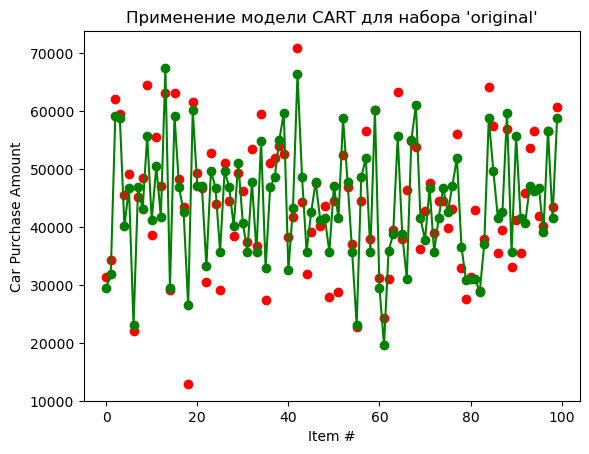

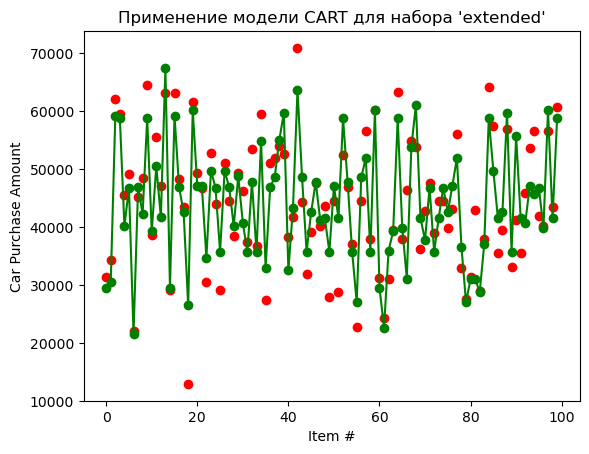

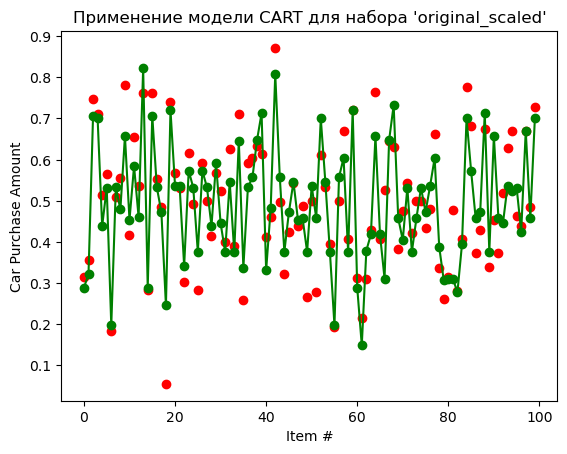

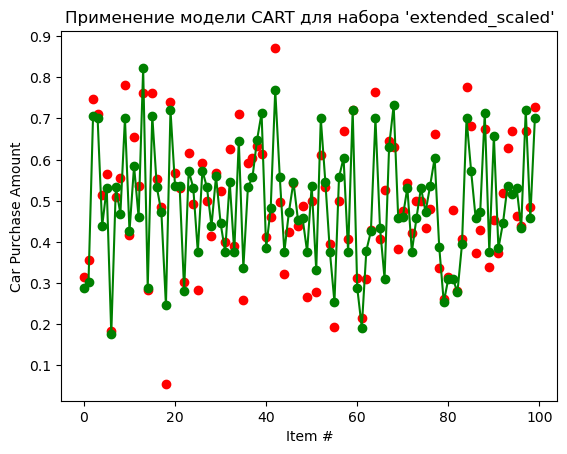

In [8]:
x_values = [i for i in range(0, len(datasets["original"]["test_Y"]))]
for key, dataset in datasets.items():
    plt.title(f"Применение модели CART для набора '{key}'")
    plt.plot(x_values,dataset["test_Y"],"ro")
    plt.plot(dataset["cart_predict"], "go")
    plt.plot(dataset["cart_predict"], "g-")
    plt.xlabel("Item #")
    plt.ylabel("Car Purchase Amount")
    plt.show()

При максимальной глубине дерева 7 модель CART показывает достаточно посредственные результаты, в 18-20 раз большую ошибку относительно лучшего найденного гиперпараметра к Лассо-регрессии.

Проведём настройку гиперпараметров для модели CART на базе обучающей выборки.

In [9]:
# Настройка гиперпараметров для CART
param_grid_cart = {
    'max_depth': [x for x in range (1,20)],  # Глубина дерева
    'min_samples_split': [x for x in range (2, 11)],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [x for x in range(1,11)]  # Минимальное количество образцов в листе
}

print("Лучшие наборы гиперпараметров для наборов данных:")
for key, dataset in datasets.items():
    # Создаем экземпляр GridSearchCV
    cart = DecisionTreeRegressor(max_depth=7, random_state=777)
    grid_search_cart = GridSearchCV(estimator=cart, param_grid=param_grid_cart,
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    
    # Обучаем GridSearchCV на обучающих данных
    grid_search_cart.fit(dataset["train_X"], dataset["train_Y"])
    
    # Получаем наилучшие гиперпараметры
    best_params_cart = grid_search_cart.best_params_
    best_cart_model = grid_search_cart.best_estimator_
    
    # Предсказание на тестовой выборке с наилучшей моделью
    y_pred_cart_best = best_cart_model.predict(dataset["test_X"])
    
    results = grid_search_cart.cv_results_

    # Оценка качества модели CART с наилучшими гиперпараметрами
    # Ищем среднеквадратичную ошибку
    y_cart_best_rmse = np.sqrt(mean_squared_error(dataset["test_Y"], y_pred_cart_best))

    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    y_cart_best_r2 = r2_score(dataset["test_Y"], y_pred_cart_best)

    print(f'Набор: {key} | RMSE: {y_cart_best_rmse:.2f} | R^2: {y_cart_best_r2:.6f} | Гиперпараметры: {best_params_cart}')

Лучшие наборы гиперпараметров для наборов данных:
Набор: original | RMSE: 4669.14 | R^2: 0.825862 | Гиперпараметры: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 6}
Набор: extended | RMSE: 4570.48 | R^2: 0.833144 | Гиперпараметры: {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 7}
Набор: original_scaled | RMSE: 0.07 | R^2: 0.828620 | Гиперпараметры: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 3}
Набор: extended_scaled | RMSE: 0.06 | R^2: 0.843798 | Гиперпараметры: {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 5}


Проведём её же на базе тестовой выборки.

In [10]:
# Настройка гиперпараметров для CART
param_grid_cart = {
    'max_depth': [x for x in range (1,20)],  # Глубина дерева
    'min_samples_split': [x for x in range (2, 11)],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [x for x in range(1,11)]  # Минимальное количество образцов в листе
}

print("Лучшие наборы гиперпараметров для наборов данных:")
for key, dataset in datasets.items():
    # Создаем экземпляр GridSearchCV
    cart = DecisionTreeRegressor(max_depth=7, random_state=777)
    grid_search_cart = GridSearchCV(estimator=cart, param_grid=param_grid_cart,
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    
    # Обучаем GridSearchCV на обучающих данных
    grid_search_cart.fit(dataset["test_X"], dataset["test_Y"])
    
    # Получаем наилучшие гиперпараметры
    best_params_cart = grid_search_cart.best_params_
    best_cart_model = grid_search_cart.best_estimator_
    
    # Предсказание на тестовой выборке с наилучшей моделью
    y_pred_cart_best = best_cart_model.predict(dataset["test_X"])
    dataset["cart_best_predict"] = y_pred_cart_best
    
    results = grid_search_cart.cv_results_

    # Оценка качества модели CART с наилучшими гиперпараметрами
    # Ищем среднеквадратичную ошибку
    y_cart_best_rmse = np.sqrt(mean_squared_error(dataset["test_Y"], y_pred_cart_best))

    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    y_cart_best_r2 = r2_score(dataset["test_Y"], y_pred_cart_best)

    print(f'Набор: {key} | RMSE: {y_cart_best_rmse:.2f} | R^2: {y_cart_best_r2:.6f} | Гиперпараметры: {best_params_cart}')

    model_results[key]["models"]["cart"] = {
        "best_params": best_params_cart,
        "best_rmse": y_cart_best_rmse,
        "best_rmse_r2": y_cart_best_r2,
    }

Лучшие наборы гиперпараметров для наборов данных:
Набор: original | RMSE: 1650.36 | R^2: 0.978244 | Гиперпараметры: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}
Набор: extended | RMSE: 2428.90 | R^2: 0.952876 | Гиперпараметры: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}
Набор: original_scaled | RMSE: 0.02 | R^2: 0.978244 | Гиперпараметры: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}
Набор: extended_scaled | RMSE: 0.04 | R^2: 0.949667 | Гиперпараметры: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 8}


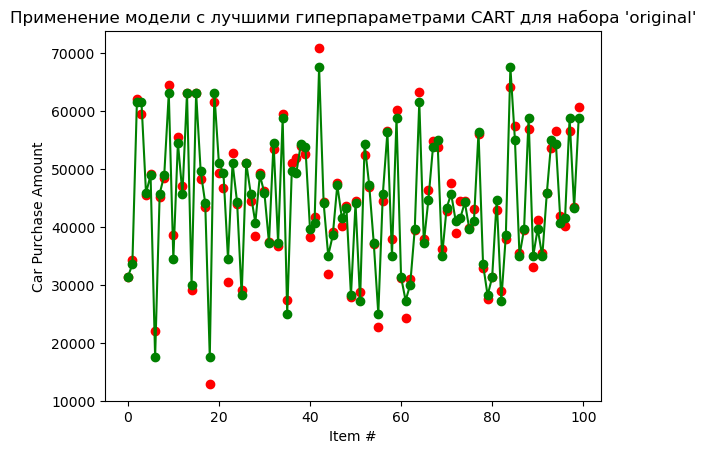

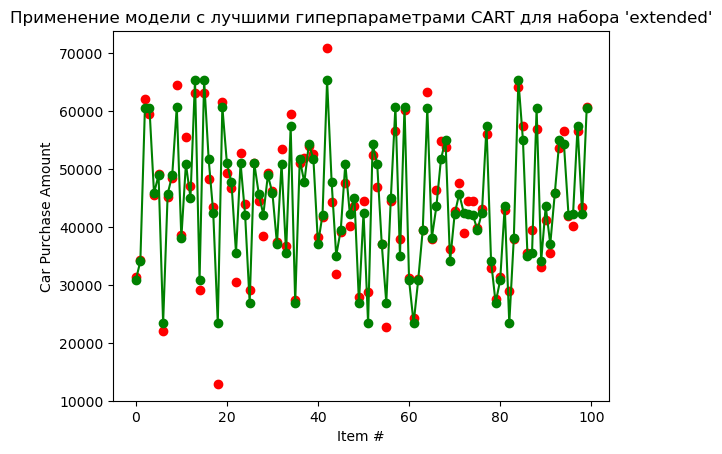

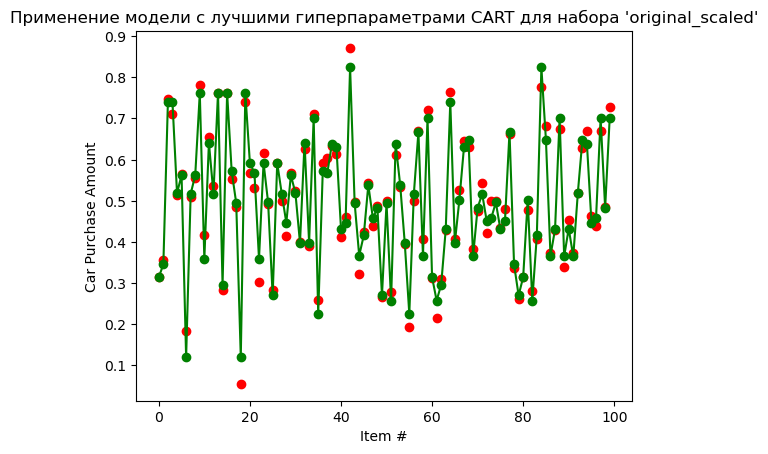

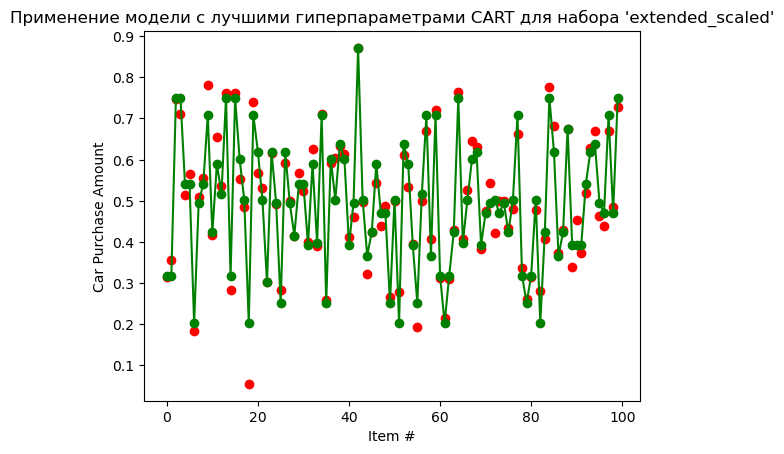

In [11]:
x_values = [i for i in range(0, len(datasets["original"]["test_Y"]))]
for key, dataset in datasets.items():
    plt.title(f"Применение модели с лучшими гиперпараметрами CART для набора '{key}'")
    plt.plot(x_values,dataset["test_Y"],"ro")
    plt.plot(dataset["cart_best_predict"], "go")
    plt.plot(dataset["cart_best_predict"], "g-")
    plt.xlabel("Item #")
    plt.ylabel("Car Purchase Amount")
    plt.show()

## 4). Построение модели на базе градиентного бустинга
Аналогично построим ансамблевую модель на базе градиентного бустинга.

In [12]:
# Применяем модели градиентного бустинга к каждому из наборов данных
print("Результаты применения градиентного бустинга:")
for key, dataset in datasets.items():
    gradboost = GradientBoostingRegressor()
    gradboost.fit(dataset["train_X"], dataset["train_Y"])
    gradboost_predict = gradboost.predict(dataset["test_X"])
    dataset["gradboost_predict"] = gradboost_predict
    dataset["gradboost_model"] = gradboost
    # Ищем среднеквадратичную ошибку
    dataset["gradboost_rmse"] = np.sqrt(mean_squared_error(dataset["test_Y"], gradboost_predict))
    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    dataset["gradboost_r2"] = r2_score(dataset["test_Y"], gradboost_predict)
    print(f'Набор: {key} | RMSE: {dataset["cart_rmse"]} | R2: {dataset["cart_r2"]}')

Результаты применения градиентного бустинга:
Набор: original | RMSE: 4938.813877427303 | R2: 0.8051664725120754
Набор: extended | RMSE: 4924.561023054001 | R2: 0.8062893846143181
Набор: original_scaled | RMSE: 0.06956075883700427 | R2: 0.8051664725120753
Набор: extended_scaled | RMSE: 0.06560597642880626 | R2: 0.8266906958311335


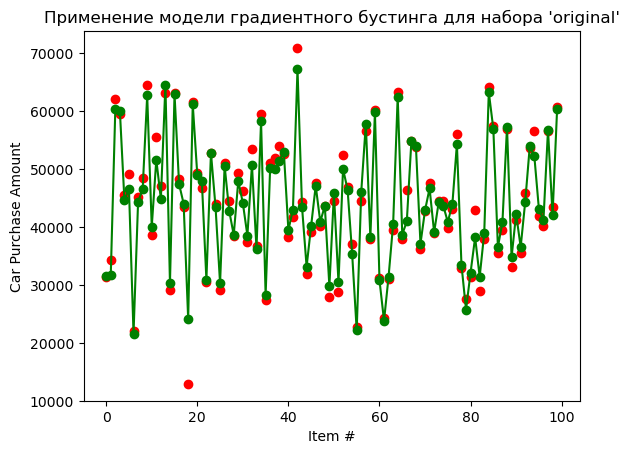

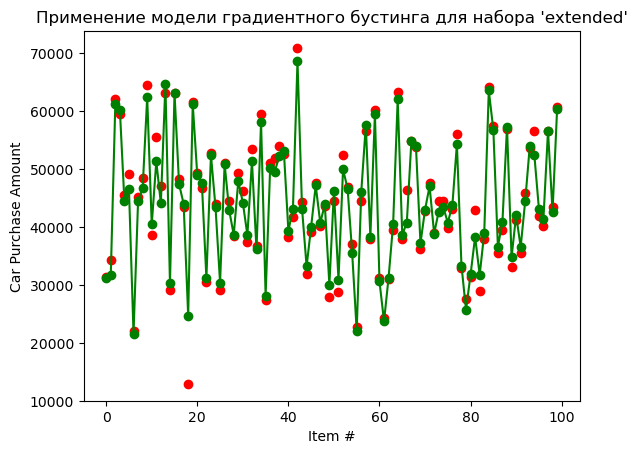

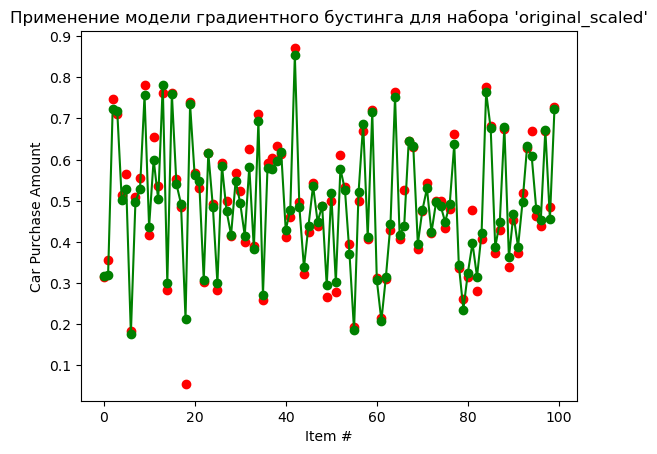

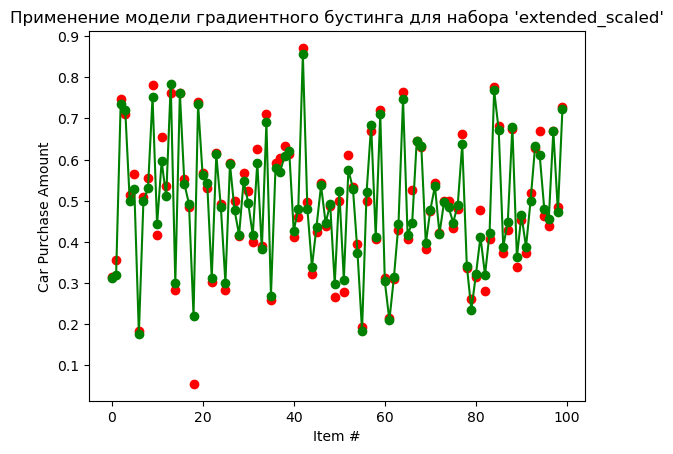

In [13]:
x_values = [i for i in range(0, len(datasets["original"]["test_Y"]))]
for key, dataset in datasets.items():
    plt.title(f"Применение модели градиентного бустинга для набора '{key}'")
    plt.plot(x_values,dataset["test_Y"],"ro")
    plt.plot(dataset["gradboost_predict"], "go")
    plt.plot(dataset["gradboost_predict"], "g-")
    plt.xlabel("Item #")
    plt.ylabel("Car Purchase Amount")
    plt.show()

Проведём настройку гиперпараметров для градиентного бустинга на базе обучающей выборки.

In [14]:
# Настройка гиперпараметров для градиентного бустинга
param_grid_gradboost = {
    'n_estimators': [50, 100, 150],  # Количество деревьев в ансамбле
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
    'max_depth': [3, 5, 7],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4]  # Минимальное количество образцов в листе
}

for key, dataset in datasets.items():
    # Создаем экземпляр GridSearchCV для Градиентного бустинга
    gradboost = GradientBoostingRegressor()
    grid_search_gradboost = GridSearchCV(estimator=gradboost, param_grid=param_grid_gradboost,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    
    # Обучаем GridSearchCV на обучающих данных
    grid_search_gradboost.fit(dataset["train_X"], dataset["train_Y"])
    
    # Получаем наилучшие гиперпараметры
    best_params_gradboost = grid_search_gradboost.best_params_
    best_gradboost_model = grid_search_gradboost.best_estimator_
    
    # Предсказание на тестовой выборке с наилучшей моделью
    y_pred_gradboost_best = best_gradboost_model.predict(dataset["test_X"])
    
    results = grid_search_gradboost.cv_results_

    # Оценка качества модели градиентного бустинга с наилучшими гиперпараметрами
    # Ищем среднеквадратичную ошибку
    y_gradboost_best_rmse = np.sqrt(mean_squared_error(dataset["test_Y"], y_pred_gradboost_best))

    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    y_gradboost_best_r2 = r2_score(dataset["test_Y"], y_pred_gradboost_best)

    # Оценка качества модели Градиентного бустинга с наилучшими гиперпараметрами
    print(f'Набор: {key} | RMSE: {y_gradboost_best_rmse:.2f} | R^2: {y_gradboost_best_r2:.6f}')
    print(f'Гиперпараметры: {best_params_gradboost}')

Набор: original | RMSE: 1793.45 | R^2: 0.974308
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Набор: extended | RMSE: 1751.62 | R^2: 0.975492
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Набор: original_scaled | RMSE: 0.03 | R^2: 0.974326
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Набор: extended_scaled | RMSE: 0.02 | R^2: 0.975539
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}


Проведём её же на базе тестовой выборки.

In [15]:
for key, dataset in datasets.items():
    # Создаем экземпляр GridSearchCV для Градиентного бустинга
    gradboost = GradientBoostingRegressor()
    grid_search_gradboost = GridSearchCV(estimator=gradboost, param_grid=param_grid_gradboost,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    
    # Обучаем GridSearchCV на обучающих данных
    grid_search_gradboost.fit(dataset["test_X"], dataset["test_Y"])
    
    # Получаем наилучшие гиперпараметры
    best_params_gradboost = grid_search_gradboost.best_params_
    best_gradboost_model = grid_search_gradboost.best_estimator_
    
    # Предсказание на тестовой выборке с наилучшей моделью
    y_pred_gradboost_best = best_gradboost_model.predict(dataset["test_X"])
    dataset["gradboost_best_predict"] = y_pred_gradboost_best
    
    results = grid_search_gradboost.cv_results_

    # Оценка качества модели градиентного бустинга с наилучшими гиперпараметрами
    # Ищем среднеквадратичную ошибку
    y_gradboost_best_rmse = np.sqrt(mean_squared_error(dataset["test_Y"], y_pred_gradboost_best))

    # Ищем значение R^2 (коэффициент детерминации, насколько хорошо модель прогнозирует данные)
    y_gradboost_best_r2 = r2_score(dataset["test_Y"], y_pred_gradboost_best)

    # Оценка качества модели Градиентного бустинга с наилучшими гиперпараметрами
    print(f'Набор: {key} | RMSE: {y_gradboost_best_rmse:.2f} | R^2: {y_gradboost_best_r2:.6f}')
    print(f'Гиперпараметры: {best_params_gradboost}')

    model_results[key]["models"]["gradboost"] = {
        "best_params": best_params_gradboost,
        "best_rmse": y_gradboost_best_rmse,
        "best_rmse_r2": y_gradboost_best_r2,
    }

Набор: original | RMSE: 96.47 | R^2: 0.999926
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Набор: extended | RMSE: 296.46 | R^2: 0.999298
Гиперпараметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Набор: original_scaled | RMSE: 0.00 | R^2: 0.999623
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Набор: extended_scaled | RMSE: 0.00 | R^2: 0.999945
Гиперпараметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


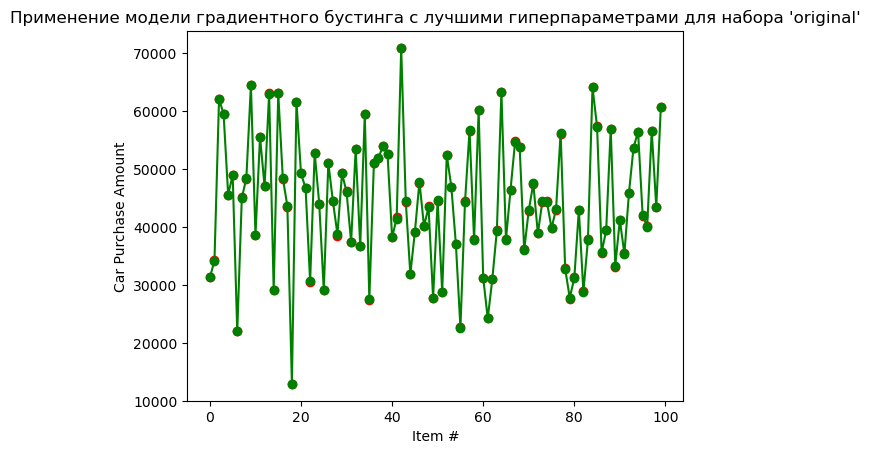

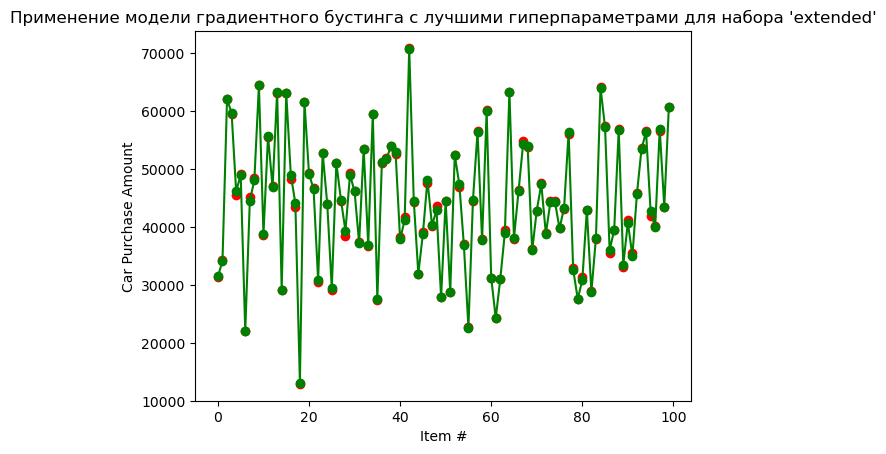

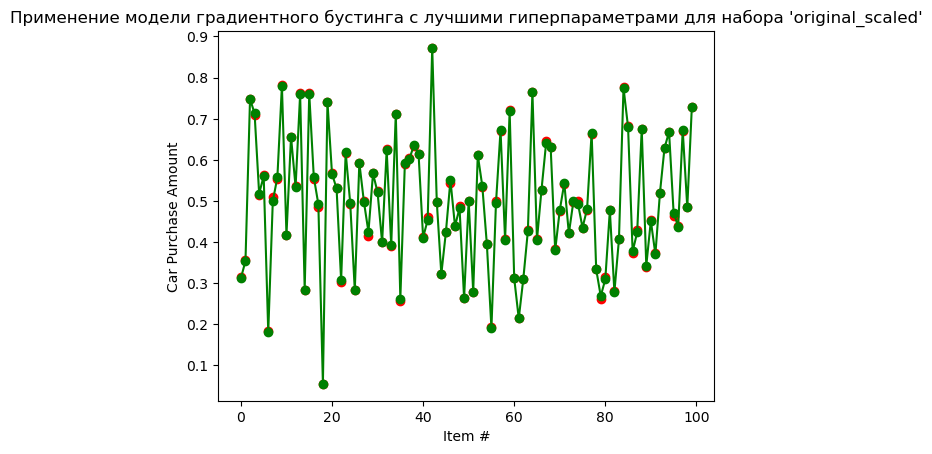

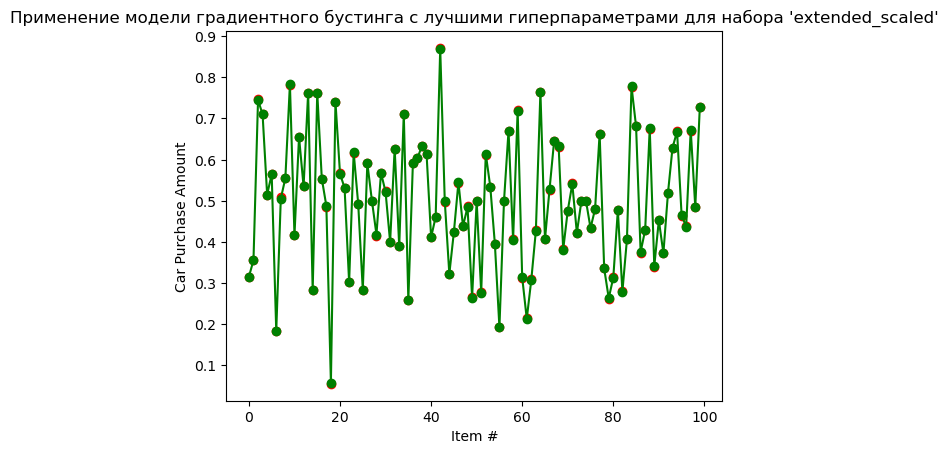

In [16]:
x_values = [i for i in range(0, len(datasets["original"]["test_Y"]))]
for key, dataset in datasets.items():
    plt.title(f"Применение модели градиентного бустинга с лучшими гиперпараметрами для набора '{key}'")
    plt.plot(x_values,dataset["test_Y"],"ro")
    plt.plot(dataset["gradboost_best_predict"], "go")
    plt.plot(dataset["gradboost_best_predict"], "g-")
    plt.xlabel("Item #")
    plt.ylabel("Car Purchase Amount")
    plt.show()

## 5). Сравнение моделей
Произведём сравнение всех 4 моделей с лучшими гиперпараметрами на каждом из наборов данных:
- Лассо-регрессия (ЛР1)
- Полиномиальная регрессия (лучшая в ЛР1)
- CART
- Градиентный бустинг
Для начала выведем данные в виде таблицы.

In [17]:
model_dataset = []
model_name = []
model_best_rmse = []
model_best_rmse_r2 = []

for key, dataset in model_results.items():
    for model, values in dataset["models"].items():
        model_dataset.append(key)
        model_name.append(model)
        model_best_rmse.append(round(values["best_rmse"],6))
        model_best_rmse_r2.append(values["best_rmse_r2"])

df_dict = {
    "Набор данных":model_dataset, 
    "Имя модели":model_name, 
    "Лучший RMSE":model_best_rmse, 
    "R^2 при лучшем RMSE":model_best_rmse_r2
}

pd.set_option('display.float_format', str)
model_df = pd.DataFrame(df_dict)
model_df

,Набор данных,Имя модели,Лучший RMSE,R^2 при лучшем RMSE
0,original,lasso,241.649378,1.0
1,original,poly,233.118647,0.9995659173746676
2,original,cart,1650.358672,0.97824420022865
3,original,gradboost,96.472297,0.9999256598200421
4,extended,lasso,241.832158,1.0
5,extended,poly,51.440363,0.9999788638236071
6,extended,cart,2428.902899,0.9528763761950259
7,extended,gradboost,296.455257,0.9992980006876832
8,original_scaled,lasso,0.003562,1.0
9,original_scaled,poly,0.0,1.0


Далее для каждого набора данных найдём модель с минимальным значением RMSE.

In [18]:
model_df.groupby("Набор данных").agg({"Лучший RMSE":"min"})

,Лучший RMSE
Набор данных,
extended,51.440363
extended_scaled,0.0
original,96.472297
original_scaled,0.0


In [20]:
print("Лучшие модели для каждого из наборов:")
for key, dataset in model_results.items():
    best = min(dataset["models"].items(), key=lambda model: model[1]["best_rmse"])
    print(f"Набор: {key} | Модель: {best[0]} | RMSE: {best[1]['best_rmse']}")

Лучшие модели для каждого из наборов:
Набор: original | Модель: gradboost | RMSE: 96.47229652638451
Набор: extended | Модель: poly | RMSE: 51.44036308777785
Набор: original_scaled | Модель: poly | RMSE: 4.911542621810573e-15
Набор: extended_scaled | Модель: poly | RMSE: 1.082997521886384e-15


Модель на базе градиентного бустинга показала наилучший результат для оригинального набора данных из 4 рассмотренных моделей. Для всех остальных наборов данных полиномиальная регрессия показала наилучшие результаты.

## 6). Выводы
В лабораторной работе произведён предиктивный анализ 4 наборов данных, взятых из лабораторной работы №1 с помощью моделей CART и градиентного бустинга. 
Произведено сравнение с моделями из предыдущей лабораторной работы. Модель на базе CART с лучшими гиперпараметрами показала значение R^2 на уровне 0.94-0.97. Модель на базе градиентного бустинга - 0.974-0.975. Лучшая модель с предыдущей ЛР (полиномиальная) показывала результы порядка 0.99-1.00.

При сравнении всех четырёх моделей по всем наборам градиентный бустинг показал лучший результат в прогнозировании данных на исходном наборе, а полиномиальная модель - на остальных трёх. 